# Дискретные случайные процессы и временные ряды, DS-поток
## Задание TS.4
### Нейросетевой подход в анализе временных рядов.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.


**Баллы за задание.** 
  * Задача 1 &mdash; 70 баллов.


In [2]:
# Bot check

# HW_ID: ds_ts4
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [3]:
import time
import datetime
from datetime import timedelta
from datetime import datetime
import random

from collections import defaultdict

import numpy as np
import pandas as pd
import scipy.stats as sps

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm.auto import tqdm
import seaborn as sns
from IPython.display import clear_output

%matplotlib inline

sns.set(font_scale=1.3, palette="Set2")

device = f"cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

___

### Задача 1
На занятии рассмотрен способ предсказания временных рядов с помощью нейронный сетей, используя как сверточные, так и рекуррентные слои. Однако, построенная модель является "разовой" &mdash; она построена по имеющимся данным до момента времени $T$ включительно, и строит рекурсивно предсказания в моменты времени $T+1, ..., T+h$. Теперь вам предстоит адаптировать модель для онлайн дообучения.

Возьмите временной ряд с семинарского занятия и разбейте его на обучающую и тестовую части. В качестве тестовой части возьмите данные за последние две недели, то есть последние $48\times14$ измерений.

In [5]:
df = pd.read_csv("electricity.txt", sep=",", index_col=0)
df.drop(
    ["DailySeasonality", "WeeklySeasonality", "Time"], axis=1, inplace=True
)

train_data = df[["Consumption", "Temperature"]][: -48 * 7]
test_data = df[["Consumption", "Temperature"]][-48 * 7 :]

train_data.head()

,Consumption,Temperature
1,3853.475392,20.90
2,3683.014105,20.70
3,3912.324031,20.50
4,3783.881181,20.05
5,3554.257244,19.60


Нормализуем

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)

train_data_normalized

array([[-0.51917527, -0.19375   ],
       [-0.60383278, -0.20625   ],
       [-0.48994882, -0.21875   ],
       ...,
       [-0.46204343, -0.521875  ],
       [-0.28224873, -0.55      ],
       [-0.28877964, -0.578125  ]])

Датасет

In [7]:
class TSDataset(Dataset):
    def __init__(self, data, n_past):
        self.data = data
        self.n_past = n_past  # tau -- длина отрезка временого ряда

    def __len__(self):
        return self.data.shape[0] - self.n_past

    def __getitem__(self, index):
        return (
            self.data[index : self.n_past + index],
            self.data[self.n_past + index],
        )

Даталоадеры

In [8]:
n_past = 48  # tau -- длина отрезка временого ряда
batch_size = 16  # размер батча

full_train_dataset = TSDataset(train_data_normalized, n_past)
generator = torch.Generator().manual_seed(0)
train_dataset, validation_dataset = random_split(full_train_dataset, lengths=[0.8, 0.2], generator=generator)
train_batch_gen = DataLoader(train_dataset, batch_size, shuffle=True)
validation_batch_gen = DataLoader(validation_dataset, batch_size, shuffle=False)

Пайплайн обучения:

In [25]:
def set_seed(seed: int):
    """Зафиксировать случайность.
    
    :param seed: int
        Инициализирующее значение
    """
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)

In [26]:
def count_trainable_parameters(model):
    """Посчитать количество обучаемых параметров модели.
    
    :return: результат подсчета
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [29]:
def plot_learning_curves(history):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации.
    """

    fig = plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["validation_loss"], label="validation")
    plt.yscale("log")
    plt.ylabel("Лосс")
    plt.xlabel("Эпоха")
    plt.legend()
    plt.show()


def evaluate_ts_model(model, start_seq, test_data):
    """
    Функция для проверки качества модели на обучающем отрезке ряда.

    :param model: обучаемая модель,
    :param start_seq: обучающие данные для первого предсказания,
    :param test_data: тестовые данные.

    :return: результаты предсказания.
    """
    result = []

    input_tensor = torch.FloatTensor(start_seq).to(device).unsqueeze(0)
    model.train(False)
    with torch.no_grad():
        for i in range(len(test_data)):
            logits = model(input_tensor[:, i:, :]).unsqueeze(0)
            input_tensor = torch.cat((input_tensor, logits), 1)
            result.append(logits.cpu().numpy().squeeze())
    return result


def plot_ts_results(result, show_from=0, lw=2):
    """
    Визуализирует результаты прогнозирования

    :param result: прогнозы
    :param show_from: с какого момента визуализировать обучающие данные
    :param lw: толщина линии
    """
    fontsize = 16
    plt.figure(figsize=(18, 8))
    plt.title("Зависимость потребления электричества от времени")
    plt.plot(
        df.index[show_from:], df.Consumption[show_from:], label="Истина", lw=lw
    )

    plt.plot(df.index[-48 * 7 :], result[:, 0], label="Предсказание", lw=lw)

    plt.xlabel("Время")
    plt.ylabel("Потребление электричества")
    plt.legend()
    plt.show()


def train_ts_model(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    validation_batch_gen,
    num_epochs=50,
):
    """
    Функция для обучения модели и вывода лосса во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param validation_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) loss на обучении ('история' обучения)
    """

    history = defaultdict(list)

    for epoch in range(num_epochs):
        train_loss = 0
        validation_loss = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой 'эпохе' делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch.type("torch.FloatTensor").to(device)
            y_batch = y_batch.type("torch.FloatTensor").to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())

        # Подсчитываем лосс и сохраням в 'историю'
        train_loss /= len(train_batch_gen)
        history["train_loss"].append(train_loss)

        # Устанавливаем поведение dropout / batch_norm  в инференс
        model.train(False)
        
        # На каждой 'эпохе' делаем оценку качества на валидации
        with torch.no_grad():
            for X_batch, y_batch in validation_batch_gen:
                X_batch = X_batch.type("torch.FloatTensor").to(device)
                y_batch = y_batch.type("torch.FloatTensor").to(device)
    
                logits = model(X_batch)
                loss = criterion(logits, y_batch)
    
                validation_loss += np.sum(loss.detach().cpu().numpy())

        # Подсчитываем лосс и сохраням в 'историю'
        validation_loss /= len(validation_batch_gen)
        history["validation_loss"].append(validation_loss)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print(
            "Эпоха {} из {} выполнена за {:.3f} сек.".format(
                epoch + 1, num_epochs, time.time() - start_time
            )
        )
        print("  train loss: \t{:.6f}".format(train_loss))
        print("  validation loss: \t{:.6f}".format(validation_loss))
        plot_learning_curves(history)

    return model, history

Постройте модель по обучающей части данных аналогично тому, как было сделано на занятии. Можно использовать, как RNN, так и Conv1D архиектуру.

На однослойной LSTM

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)

        self.out_net = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=self.output_size),
        ) 

    def forward(self, input_seq):
        # input_seq.shape = [batch_size, 2, 48]

        # lstm_out.shape = [batch_size, 48, hidden_size]
        # hidden_state.shape = [1, batch_size, hidden_size]
        lstm_out, (hidden_state, _) = self.lstm(input_seq)

        # predictions.shape = [batch_size, 2]
        predictions = self.out_net(hidden_state.squeeze(0))
        return predictions

Объявляем модель

In [13]:
set_seed(0)
lstm_model = LSTM(input_size=2, output_size=2, hidden_size=128)
print(f"Число обучаемых параметров: {count_trainable_parameters(lstm_model)}")
lstm_model.to(device)

Число обучаемых параметров: 67842


LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (out_net): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
  )
)

И обучаем ее

Эпоха 90 из 90 выполнена за 1.210 сек.
  train loss: 	0.000405
  validation loss: 	0.000546


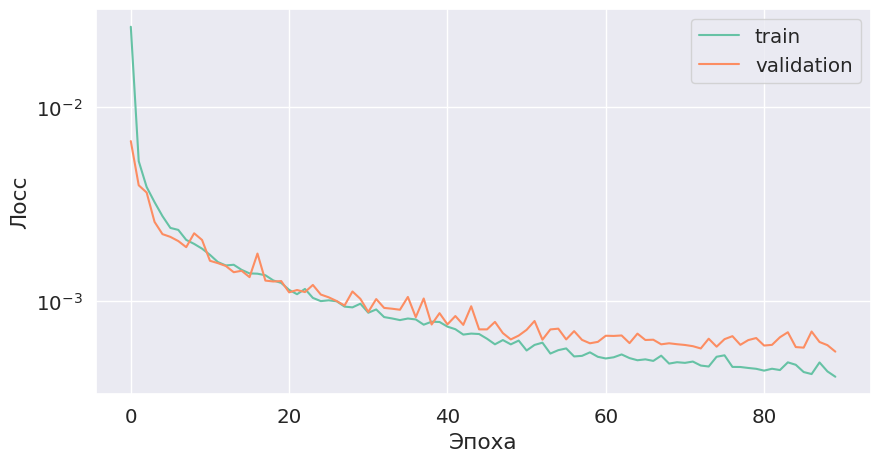

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)

lstm_model, _ = train_ts_model(
    lstm_model, criterion, optimizer, train_batch_gen, validation_batch_gen, num_epochs=90
);

Получаем результаты на тестовых данных

In [15]:
start_seq = train_data_normalized[-n_past:]
lstm_result = evaluate_ts_model(lstm_model, start_seq, test_data_normalized)

Применяем обратное преобразование к результатам, чтобы убрать нормализацию

In [16]:
lstm_result = np.array(lstm_result, ndmin=2)
lstm_result = scaler.inverse_transform(lstm_result)

Подсчитываем ошибку предсказания потребления электричества

In [17]:
y_truth = test_data["Consumption"]
rmse = np.sqrt(((lstm_result[:, 0] - y_truth) ** 2).mean())
print("RMSE на тестовых данных = {:.3f}".format(rmse))

RMSE на тестовых данных = 458.195


Визуализируем результаты предсказания

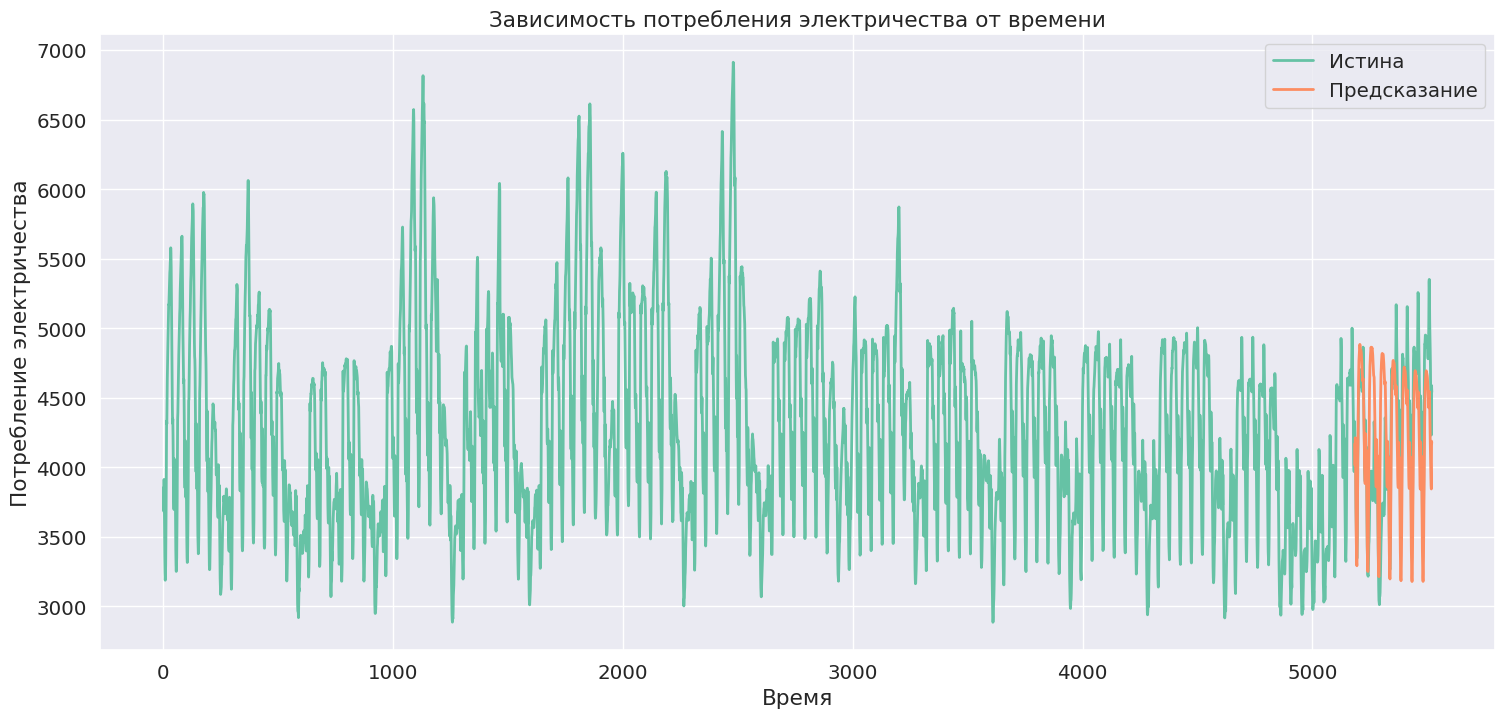

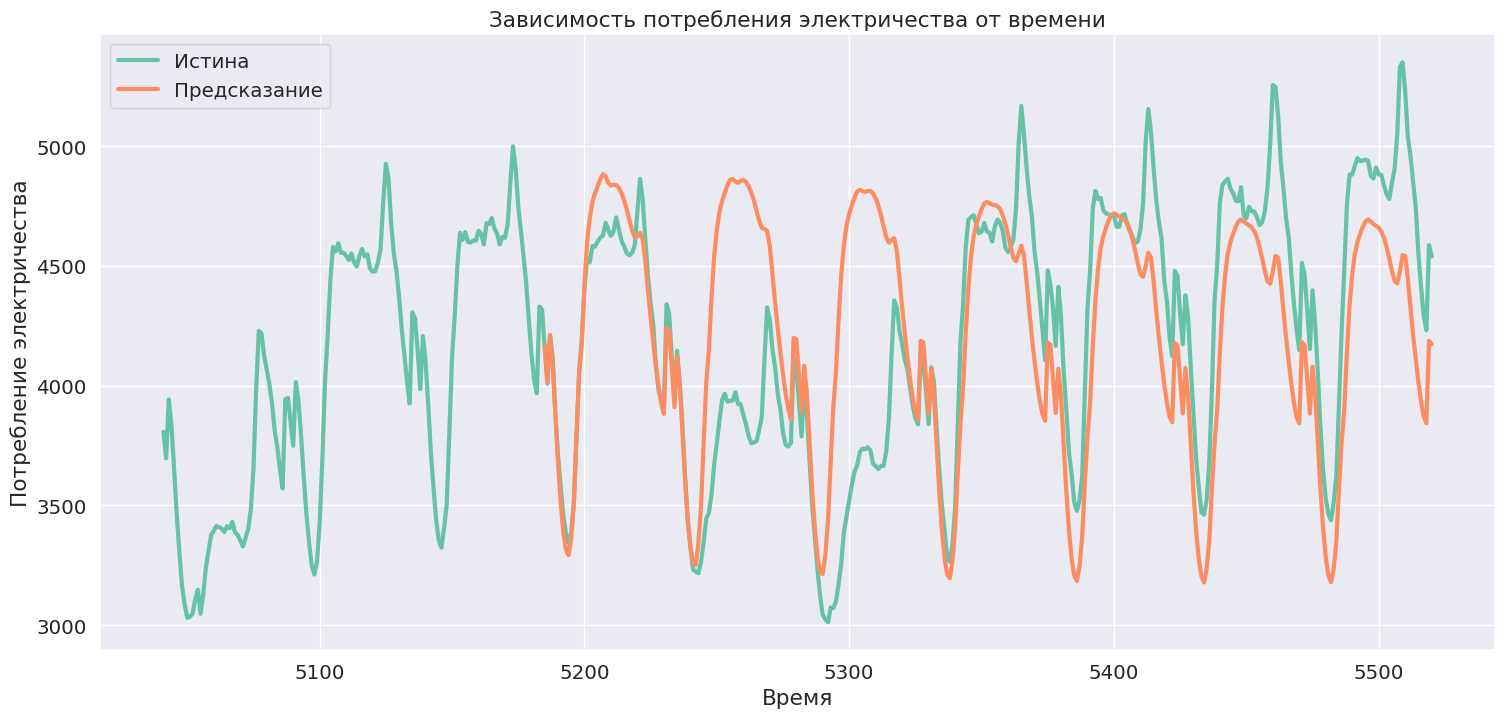

In [18]:
plot_ts_results(lstm_result)
plot_ts_results(lstm_result, show_from=48 * 7 * 15, lw=3)

Зафиксируем некоторые константы:
* $h = 48\times7\ измерений = 7\ суток$ &mdash; горизонт прогнозирования;
* $\tau = 24\ измерения = 12\ часов$ &mdash; периодичность дообучения.

Теперь обсудим как должна выглядеть процедура дообучения. Пусть мы находимся в момент времени $T$ и уже обучили модель на всех имеющихся данных до момента времени $T$. Тогда необходимо выполнить следующие шаги.
1. Построить прогнозы на $h$ измерений вперед по одному наблюдению рекурсивно.
2. Подождать, пока поступят следующие $\tau$ измерений, и добавить их к обучающей выборке.
3. При необходимости удалить из обучающей выборки несколько старых измерений.
4. Произвести несколько итераций backpropagation для имеющейся нейронной сети и вернуться к шагу 1.

Вам необходимо реализовать эту процедуру и просимулировать ее применение. Стартовать следует из состояния, в котором модель обучена только на обучающей части временного ряда. После каждой итерации рисуйте график, на котором отображены:
* обучающая и тестовая часть данных разными цветами;
* прогнозы на данной итерации;
* текущий момент времени вертикальной пунктирной линией.

Таким образом, у вас должна получиться последовательность графиков, которая позволит проследить динамику дообучения. Стройте графики так, чтобы их можно было визуально сравнивать. 

Кроме того, после каждой итерации считайте ошибку прогнозирования по метрикам RMSE, MAE, MAPE 
- на длину горизонта прогнозирования $h$,
- на $\tau$ измерений вперед.

Постройте **графики изменения ошибок** при дообучении модели.

Для экспериментов полезно использовать
* `IPython.display.clear_output(wait=True)` &mdash; непосредственно до начала отрисовки каждого графика для его непрерывного обновления, **отключите эту команду при финальном запуске перед отправкой на проверку**;
* `time.sleep(some_seconds)` &mdash; визуальная задержка в момент поступления новых данных.

Предварительно обучим на трети данных, затем будем дообучать

In [33]:
h = 48 * 7
tau = 24
n_past = 48
batch_size = 16

initial_train_size = len(train_data_normalized) // 3
current_train = train_data_normalized[:initial_train_size]
all_data = np.concatenate([train_data_normalized[initial_train_size:], test_data_normalized])

model = LSTM(input_size=2, output_size=2, hidden_size=128).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

metrics = {
    'rmse_h': [], 'mae_h': [], 'mape_h': [],
    'rmse_tau': [], 'mae_tau': [], 'mape_tau': []
}

Обучение модели

In [91]:
def train_model_step(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    data_normalized,
    current_train_size,
    history,
    num_epochs=2,
):
    """
    Функция для обучения модели на текущих данных и подсчета метрик

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param validation_batch_gen: генератор батчей для валидации
    :param history: сохранение метрик
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) loss на обучении ('история' обучения)
    """

    for epoch in range(num_epochs):
        model.train(True)
        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch.type("torch.FloatTensor").to(device)
            y_batch = y_batch.type("torch.FloatTensor").to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    model.train(False)
    model.eval()
    predictions = []
    current_sequence = data_normalized[current_train_size - n_past : current_train_size].copy()
    
    with torch.no_grad():
        for _ in range(h):
            input_tensor = torch.FloatTensor(current_sequence[-n_past:]).unsqueeze(0).to(device)
            pred = model(input_tensor).cpu().numpy().squeeze()
            predictions.append(pred)
            current_sequence = np.vstack([current_sequence, pred])

    predictions = np.array(predictions)
    true_values = data_normalized[current_train_size : current_train_size + h]
    
    pred_consumption = scaler.inverse_transform(predictions)[:,0]
    true_consumption = scaler.inverse_transform(true_values)[:,0]

    history['rmse_h'].append(np.sqrt(mean_squared_error(true_consumption, pred_consumption)))
    history['mae_h'].append(mean_absolute_error(true_consumption, pred_consumption))
    history['mape_h'].append(np.mean(np.abs((true_consumption - pred_consumption)/true_consumption)) * 100)
    
    history['rmse_tau'].append(np.sqrt(mean_squared_error(true_consumption[:tau], pred_consumption[:tau])))
    history['mae_tau'].append(mean_absolute_error(true_consumption[:tau], pred_consumption[:tau]))
    history['mape_tau'].append(np.mean(np.abs((true_consumption[:tau] - pred_consumption[:tau])/true_consumption[:tau])) * 100)

    history['pred'].append(pred_consumption)
    history['true'].append(true_consumption)
    history['current_idx'].append(current_train_size)
    
    return 

Обучаем - сначала 80 эпох на первой трети обучающих данных, затем, добавляя по 12 часов, на предыдущих 4 неделях

In [ ]:
start_train_size = len(train_data_normalized) // 3

model = LSTM(input_size=2, output_size=2, hidden_size=128).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

history = defaultdict(list)

iterations = range(
    len(train_data_normalized) // 3, 
    len(train_data_normalized) - tau * 2, 
    tau
)

for i, current_size in tqdm(enumerate(iterations), total=len(iterations), desc="Обучение модели"):
    current_train_dataset = TSDataset(train_data_normalized[(i != 0) * max(0, current_size - 2 * h) : current_size], n_past)
    train_batch_gen = DataLoader(current_train_dataset, batch_size=16, shuffle=True)

    train_model_step(
        model, criterion, optimizer, train_batch_gen,
        train_data_normalized, current_size, history, num_epochs=4 + (i == 0) * 80
    )


Графики метрик

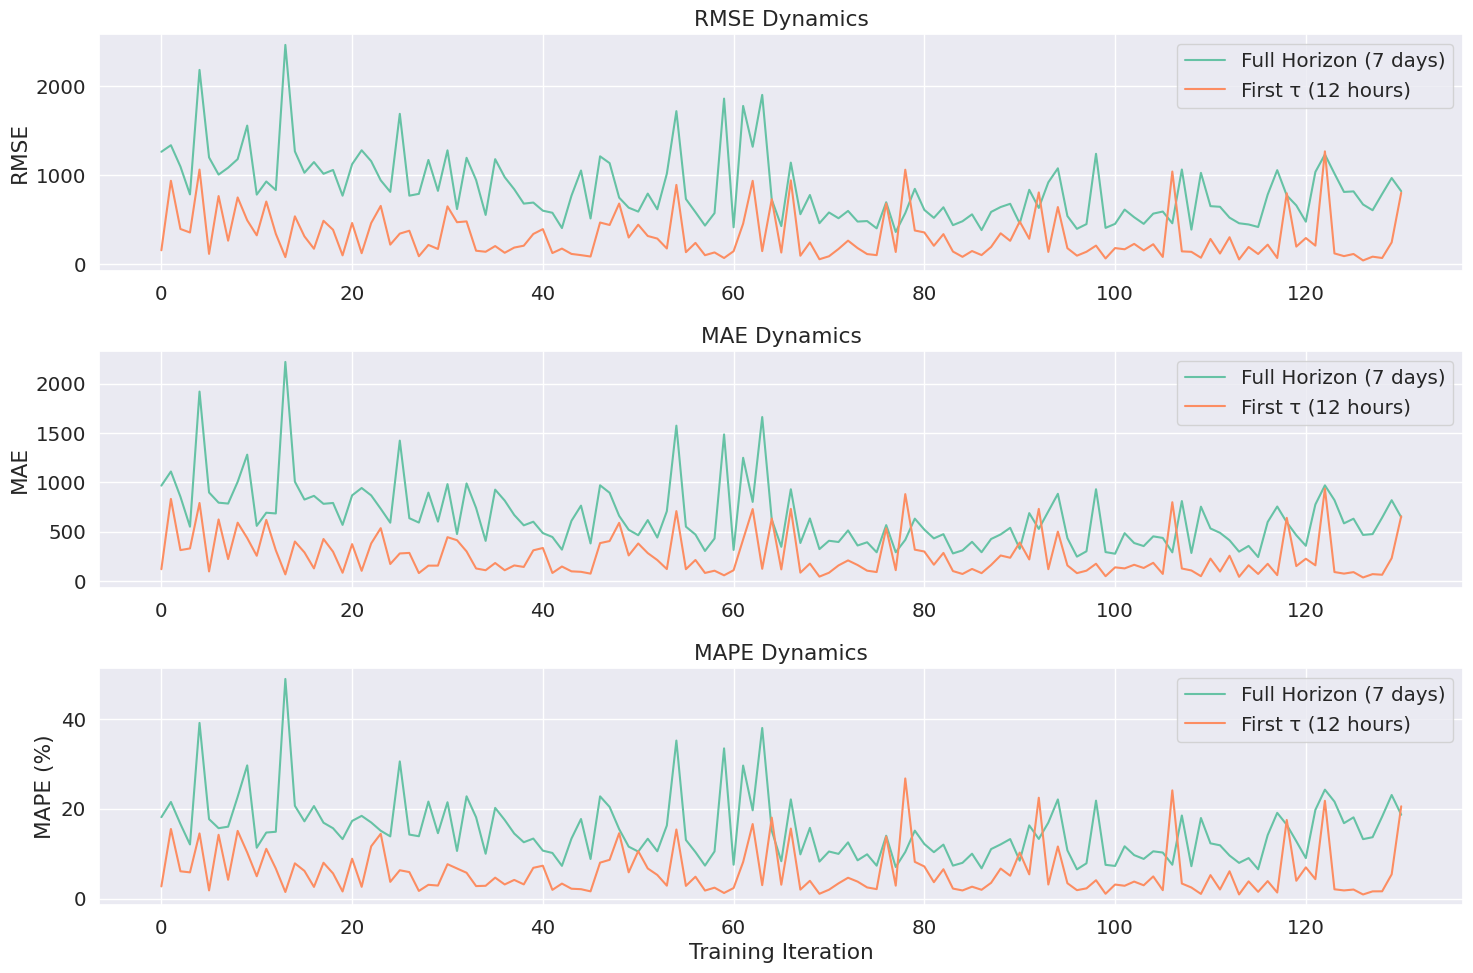

In [93]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(history['rmse_h'], label='Full Horizon (7 days)')
plt.plot(history['rmse_tau'], label='First τ (12 hours)')
plt.title('RMSE Dynamics')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(history['mae_h'], label='Full Horizon (7 days)')
plt.plot(history['mae_tau'], label='First τ (12 hours)')
plt.title('MAE Dynamics')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(history['mape_h'], label='Full Horizon (7 days)')
plt.plot(history['mape_tau'], label='First τ (12 hours)')
plt.title('MAPE Dynamics')
plt.ylabel('MAPE (%)')
plt.xlabel('Training Iteration')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Интерактивный график предсказаний

In [115]:
from ipywidgets import interact, IntSlider

def plot_iteration(iter_idx):
    plt.figure(figsize=(18, 8))

    current_size = history['current_idx'][iter_idx]
    pred = history['pred'][iter_idx]
    true = history['true'][iter_idx]
    
    train_consumption = scaler.inverse_transform(train_data_normalized)[:,0]
    test_consumption = scaler.inverse_transform(test_data_normalized)[:,0]
    pred_consumption = pred 
    
    full_index = df.index
    
    plt.plot(full_index[:len(train_consumption)], 
             train_consumption, 
             label='Все тренировочные данные', color='blue', linewidth=1)
    
    plt.plot(full_index[max(0, current_size - 2 * h):current_size], 
             train_consumption[max(0, current_size - 2 * h):current_size], 
             label='Тренировочные данные текущей итерации', color='red', linewidth=1)
    
    plt.plot(full_index[len(train_data_normalized):], 
             test_consumption,
             label='Тестовые данные', color='green', linewidth=1)
    
    plt.plot(full_index[current_size:current_size + h], 
             pred_consumption, 
             label='Предсказание', linestyle='--', color='orange', linewidth=1)
    
    plt.axvline(current_size, color='red', linestyle='--', linewidth=1)
    plt.axvline(full_index[len(train_data_normalized)], 
                color='purple', linestyle=':', linewidth=1)
    
    plt.title(f'Прогноз на итерации {iter_idx+1}')
    plt.xlabel('Время')
    plt.ylabel('Потребление электроэнергии')
    plt.legend()
    plt.grid(True)
    plt.show()

Ниже можно тыкать со слайдером

In [116]:
interact(
    plot_iteration,
    iter_idx=IntSlider(
        min=0,
        max=len(history['current_idx'])-1,
        step=1,
        value=0,
        description='Итерация:',
        continuous_update=False
    )
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Итерация:', max=130), Output())…

<function __main__.plot_iteration(iter_idx)>

Сделайте выводы.

Итоговое предсказание модели не очень стабильно и зависит от номера итерации. Мы дообучаем модель на последних данных, поэтому она переобучается под них. Это бывает может быть хорошо, например, когда происходит резкий перелом тренда, а модель его начинает чувствовать. Хорошо бы в модель добавить параметры, связанные с экзогенными факторами времени, типа синуса или косинуса от даты, тогда предсказание будет более стабильным.

Поэтому результат по сравнению с предыщей моделью улучшился

In [102]:
result = evaluate_ts_model(model, start_seq, test_data_normalized)
result = np.array(result, ndmin=2)
result = scaler.inverse_transform(result)
y_truth = test_data["Consumption"]
rmse = np.sqrt(((result[:, 0] - y_truth) ** 2).mean())
print("RMSE на тестовых данных = {:.3f}".format(rmse))

RMSE на тестовых данных = 421.389


Существенного улучшения не получилось в связи с недостаточной мощностью модели